<a href="https://colab.research.google.com/github/thotran2015/6.871/blob/master/ps2_Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2: Clinical NLP for De-identification

## Task
As outlined in the problem overview, in this problem we will be working with the n2c2 2014 challenge, de-identification track data. This challenge tasks participants to design models to ingest clinical notes and identify regions of Personal Health Information (PHI), so that they can be automatically obfuscated by de-identification systems. For example, if a note said 

  > Dr. Pompies perscribed Deniz Aslan a daily antibiotic after a visit to The Hospital for Doctoring

then the system should flag "Pompies", "Deniz Aslan" as names for obfuscation, and "The Hospital for Doctoring" as the name of a hospital for obfuscation. We work with these labels via a variant of the [IOB2](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) system, where we tag the _beginnings_ of spans of PHI with a "B-" prefixed label (the label suffix indicates what kind of PHI the span is), the _inside_ of spans of PHI with an "I-" tag, and all non-PHI tokens (the _outside_ of spans of PHI) with an "O" label. This format is commonly used in clinical NER tasks. The labels for our example sentence above would thus be

  > O B-DOCTOR O B-PATIENT I-PATIENT O O O O O O O B-HOSPITAL I-HOSPITAL I-HOSPITAL I-HOSPITAL

Note that while the data we use in this problem does come from the n2c2 task, for reasons of technical expedience we don't evaluate in a manner consistent with the official challenge evaluation,so your results will not be consistent with published numbers.

### Outline
In this notebook, first, we'll have some imports and helper functions, then we'll work through some data exploration and baseline methods, followed by methods using recurrent neural networks to acheive better performance.

## Import, constants, and helper functions
Do not modify this section. Note that after exectuing the first cell, you will need to restart the runtime for the package installations to take effect. Additionally, after you complete this initial restart, make sure you upload the provided data files by clicking on the folder icon on the left, then clicking "Upload", then selecting the provided data files. Do not navigate to other folders than the default folder. If you accidentally navigate out to the full file tree, the default folder is `content`.


In [1]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
!pip install allennlp

import pandas as pd, numpy as np, matplotlib.pyplot as plt

from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm_notebook as tqdm

     | 727kB 11.5MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=1113994baa732474fc0a82b0029f40dab313fec54867da15cab2e8ff4ea7876d
  Stored in directory: /tmp/pip-ephem-wheel-cache-pthbvy6a/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


     |████████████████████████████████| 7.6MB 4.8MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 133kB 51.6MB/s 
     |████████████████████████████████| 204kB 51.5MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 163kB 52.0MB/s 
     |████████████████████████████████| 256kB 51.0MB/s 
     |████████████████████████████████| 245kB 44.4MB/s 
     |████████████████████████████████| 1.0MB 38.6MB/s 
  Created wheel for parsimonious: filename=parsimonious-0.8.1-cp36-none-any.whl size=42712 sha256=f259e70873a25077aebb20880358a42f98f9f3d3bbbf377074f77dc451777e91
  Stored in directory: /root/.cache/pip/wheels/b7/8d/e7/a0e74217da5caeb3c1c7689639b6d28ddbf9985b840bc96a9a
  Created wheel for ftfy: filename=ftfy-5.7-cp36-none-any.whl size=44593 sha256=603b322b58811acdd005a41090dbc6dab0b45045a04f06d3be504bbaae047874
  Stored in directory: /root/.cache/pip/wheels/8e/da/59/6c8925d571aacade638a0f515960c2

In [0]:
RARE_WORDS_THRESHOLD = 4
UNK = " _ UNK _ "
PAD = " _ PAD _ "
PUNCT = "PUNCTUATION"
NUM = "#"

In [0]:
def read_dataset_file(filepath):
  with open(filepath, mode='r') as f: lines = f.readlines()
  out, sentence = [], []
  for line in lines:
    if not line.strip(): 
      out.append(sentence)
      sentence = []
    else: 
      word, label = line.strip().split()
      sentence.append((word, label))
  return out

train = read_dataset_file('2014_train.tsv')
dev = read_dataset_file('2014_dev.tsv')
test = read_dataset_file('2014_test.tsv')

In [0]:
def ner_eval(
    probs, true, label_vocab, metric='Macro F1',
):
  """
  Simple, *NON-OFFICIAL* evaluation script. 
  probs: [ sentence 1: [[probabilities_per_label for word 1], ... ], ...]
  true: [ sentence 1: [(word_1, label_1), ...], ...]
  label_vocab: [labels in order of elements of probability vectors.]
  metric = {'F1', ...}
  """
  label_idxmap = {l: i for i, l in enumerate(label_vocab)}

  assert metric == 'Macro F1', "Metric %s not supported" % metric

  if metric == 'Macro F1':
    flat_preds = [probs.argmax() for sent in probs for probs in sent]
    flat_true = [label_idxmap[
        l if l in label_idxmap else PAD
    ] for sent in true for _, l in sent]
    score = f1_score(flat_true, flat_preds, average='macro')
  
  return score

## Dataset Exploration
Now that we've loaded our data, let's take a look at its format.

### Examining the Data Directly
What can we see here about this data? We can observe both technical properties, about how the data is organized, and conceptual factors, such as the kinds of labels present in the data.

#### Technical Factors
Let's print some stats about our dataset, like its size, and show some examples to see if we can understand the format.

In [7]:
train_len = len(train)
dev_len = len(dev)
test_len = len(test)

train_lens = [len(s) for s in train]
dev_lens = [len(s) for s in dev]

print(
    "Train contains %d sentences, ranging from %d - %d (avg %d) words long."
    "" % (train_len, min(train_lens), max(train_lens), np.mean(train_lens))
)
print("Train Samples:")
print(train[0])
print(train[1])

print(
    "Dev contains %d sentences, ranging from %d - %d (avg %d) words long."
    "" % (dev_len, min(dev_lens), max(dev_lens), np.mean(dev_lens))
)
print("Test contains %d sentences." % test_len)

Train contains 46080 sentences, ranging from 1 - 878 (avg 9) words long.
Train Samples:
[('Record', 'O'), ('date:', 'O'), ('2098-04-01', 'B-DATE')]
[('Mr.', 'O'), ('Fredrick', 'B-PATIENT'), ('is', 'O'), ('a', 'O'), ('48', 'B-AGE'), ('-year-old', 'O'), ('man', 'O'), ('status', 'O'), ('post', 'O'), ('right', 'O'), ('middle', 'O'), ('lobectomy', 'O'), ('on', 'O'), ('September', 'B-DATE'), ('24,', 'I-DATE'), ('2096', 'I-DATE'), (',', 'O'), ('for', 'O'), ('T1N0', 'O'), ('carcinoid.', 'O'), ('He', 'O'), ('has', 'O'), ('had', 'O'), ('no', 'O'), ('complaints,', 'O'), ('since', 'O'), ('that', 'O'), ('time,', 'O'), ('and', 'O'), ('denies', 'O'), ('any', 'O'), ('stridor,', 'O'), ('wheezing,', 'O'), ('productive', 'O'), ('cough,', 'O'), ('shortness', 'O'), ('of', 'O'), ('breath,', 'O'), ('hemoptysis', 'O'), ('or', 'O'), ('fever.', 'O'), ('He', 'O'), ('has', 'O'), ('gained', 'O'), ('several', 'O'), ('pounds,', 'O'), ('but', 'O'), ('is', 'O'), ('otherwise', 'O'), ('feeling', 'O'), ('well.', 'O')]
De

It appears our data-loaders have loaded the files in such a way that `train` or `dev` contains a list, where each element of the list corresponds to a sentence or line in a clinical note, represented as a list of tuples, each containing first the _word_ at that position in the sentence, followed by the _label_ of that word. Note that the underlying file format we use, if you choose to inspect that, is a common format for use with the BERT model and NER (though we won't use BERT in this assignment).

Note the size discrepancy between our dev dataset and test dataset. In general, seeing such a large difference would be cause for concern -- perhaps these were not sampled in an iid manner, but instead obtained from different sources and this explains the delta in size. Here, however, it is merely that the original source data for this task used a 60/40 train-test split, which is abnormally large, and our selected dev set (randomly chosen from the original data) is only a 10% split. See here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4989908/ for more details

#### Labels present
Stripping off the IOB format prefixes (`B-`, `I-`), we see that we have 24 PHI categories, including non-PHI (`O`). Normally, you'd need to investigate the data generative process, or speak to your clinical collaborators to understand the exact meaning of these labels, but in this case, you can refer to the published paper describing this dataset for more information on the meaning of each of these labels: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4989908/

In [8]:
train_labels = set(l for sent in train for w, l in sent)
# Note that, in reality, we won't be able to use the labels we add below from
# dev in any model decisions if it is to truly simulate a held out test set.
dev_labels = set(l for sent in dev for w, l in sent)
test_labels = set(l for sent in read_dataset_file('2014_test.tsv') for w, l in sent)

print(dev_labels - train_labels)
print(test_labels - train_labels)

all_labels = train_labels
all_labels.update(dev_labels)
all_labels.update(test_labels)

phi_categories = set(l if l == 'O' else l[2:] for l in all_labels)
phi_category_counts = Counter(
    (l if l == 'O' else l[2:]) for sent in train for _, l in sent
)
print(
    "All %d PHI Types: \n"
    "%s"
    "" % (
        len(phi_categories),
        '\n'.join('  %s: %d' % e for e in phi_category_counts.most_common())
    )
)

set()
{'I-DEVICE'}
All 24 PHI Types: 
  O: 427526
  DATE: 7487
  DOCTOR: 4463
  HOSPITAL: 2272
  PATIENT: 1814
  AGE: 1115
  MEDICALRECORD: 577
  STREET: 571
  CITY: 416
  PROFESSION: 394
  PHONE: 336
  STATE: 286
  IDNUM: 258
  USERNAME: 251
  ORGANIZATION: 200
  ZIP: 183
  COUNTRY: 69
  LOCATION-OTHER: 8
  FAX: 8
  DEVICE: 7
  URL: 6
  EMAIL: 2
  HEALTHPLAN: 2
  BIOID: 1


### Word Frequencies
Now, let's examine the words observed

In [0]:
words_and_labels = Counter(w_and_l for sent in train for w_and_l in sent)
vocab = Counter(w for sent in train for w, l in sent)
labels = Counter(l for sent in train for w, l in sent)

In [11]:
rare_words = Counter({w: cnt for w, cnt in vocab.items() if cnt < RARE_WORDS_THRESHOLD})
rest_words = Counter({w: cnt for w, cnt in vocab.items() if cnt >= RARE_WORDS_THRESHOLD})

rare_words_aggregated = {
    l: sum(words_and_labels[(w, l)] for w in rare_words) for l in labels
}

print(
    "Extracted %d rare words of %d total (%.2f%%)" % (
        len(rare_words), len(vocab), len(rare_words)/len(vocab) * 100
    )
)
print("Sample Rare words", list(rare_words.items())[:5])
print("Sample Common words", list(rest_words.items())[:5])

Extracted 36256 rare words of 48426 total (74.87%)
Sample Rare words [('2098-04-01', 1), ('carcinoid.', 3), ('stridor,', 3), ('130/88,', 1), ('89.', 1)]
Sample Common words [('Record', 731), ('date:', 710), ('Mr.', 216), ('Fredrick', 7), ('is', 4812)]


That's a lot of rare words. This could cause problems in our analysis later, and may indicate issues with our (currently extremely simple) tokenization.

## Baselines
### A Simple, Unigram Baseline
First, we'll experiment with a simple, per-word baseline. Normally, we might consider making a linear model with a unigram, bag-of-words baseline as our simplest baseline. However, some consideration points out that a linear model with _unigram_ inputs is simply asking the model to assign optimal probabilities to each word indepedently, and these we can compute more efficiently, so we'll do that here as our simplest baseline. All we need to do is count how often each label is assigned to any unique word in our train set (aggregating together all rare words into an "UNKNOWN" bucket so we can still predict on unseen words at test time), then normalize by word to get probabilities. Note that if you change the `RARE_WORDS_THRESHOLD` variable, this cell may take a long time to compute, but at the default parameters, should take only seconds.

In [12]:
%%time
all_data = [(w,l,cnt) for (w,l), cnt in words_and_labels.items() if w in rest_words]
for label in labels.keys():
  all_data.append((UNK, label, rare_words_aggregated[label]))

labeling_rates = pd.DataFrame(all_data, columns = ('word', 'label', 'count'))

labeling_rates = labeling_rates.pivot_table(
    index='word', columns='label', values='count'
)
labeling_rates.fillna(0, inplace=True)

# Convert counts into per-word probabilities
labeling_rates = labeling_rates.div(labeling_rates.sum(axis=1), axis='index')

CPU times: user 83.3 ms, sys: 12.9 ms, total: 96.2 ms
Wall time: 131 ms


What does our output look like? A table with word as our index key, and each row giving the probabilities for all label types.

In [26]:
labeling_rates.head()

label,B-AGE,B-BIOID,B-CITY,B-COUNTRY,B-DATE,B-DEVICE,B-DOCTOR,B-EMAIL,B-FAX,B-HEALTHPLAN,B-HOSPITAL,B-IDNUM,B-LOCATION-OTHER,B-MEDICALRECORD,B-ORGANIZATION,B-PATIENT,B-PHONE,B-PROFESSION,B-STATE,B-STREET,B-URL,B-USERNAME,B-ZIP,I-AGE,I-CITY,I-COUNTRY,I-DATE,I-DOCTOR,I-FAX,I-HEALTHPLAN,I-HOSPITAL,I-IDNUM,I-LOCATION-OTHER,I-MEDICALRECORD,I-ORGANIZATION,I-PATIENT,I-PHONE,I-PROFESSION,I-STATE,I-STREET,I-URL,O
word,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
_ UNK _,0.000177,0.00002,0.00503,0.000963,0.068598,0.000138,0.024385,0.000039,0.000118,0.0,0.011299,0.004618,0.000039,0.007722,0.001533,0.009727,0.005305,0.002653,0.001041,0.001297,0.00002,0.00171,0.002692,0.0,0.000629,0.000118,0.001297,0.017469,0.00002,0.0,0.002947,0.000275,0.000059,0.00002,0.000884,0.003871,0.000747,0.001788,0.000059,0.002731,0.00002,0.817944
"""",0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
"""a",0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
"""chest",0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
#,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000


We see that many words are _never_ seen to be any of our "PHI" labels here (B-\*, I-\*). However, the block in which we've aggregated rare words shows pretty diverse labels, as shown in the plot below.

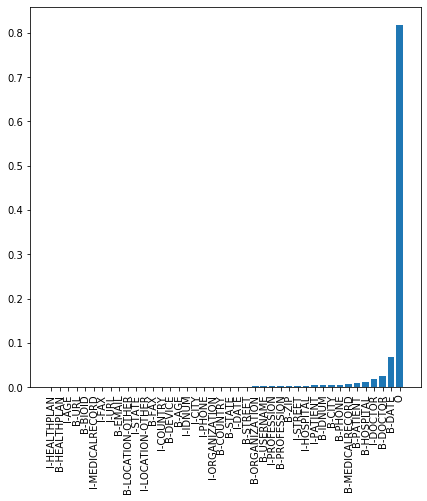

In [27]:
fig, ax = plt.subplots(figsize=(7, 7))
data = labeling_rates.loc[UNK].sort_values()
ax.bar(data.index, data.values)
ax.tick_params(rotation=90, axis='x')

Now we can make some actual predictions on the validation dataset and evaluate via our per-word macro F1 metric:

In [28]:
%%time
dev_probs = []
for sent in dev:
  sent_probs = []
  for w, _ in sent:
    w = w if w in rest_words else UNK
    probabilities = labeling_rates.loc[w]
    sent_probs.append(probabilities.values)
  dev_probs.append(sent_probs)

unigram_dev_F1 = ner_eval(dev_probs, dev, list(labeling_rates.columns) + [PAD])
print("We obtain a Dev F1 of %.2f" % unigram_dev_F1)

We obtain a Dev F1 of 0.17
CPU times: user 7.16 s, sys: 13.3 ms, total: 7.17 s
Wall time: 7.17 s


### An Improved Baseline
As far as Macro-F1s go, this isn't great. Note that this isn't a comparable metric to the true SOTA for this task, which uses an exact F1 measure comparing predicted spans, as opposed to our crude, per-word metric here. But still, we can do better.

We'll now work through a more involved baseline, which will incorporate 3 primary changes:
  1. An improved tokenization of the data.
  2. An n-gram model incorporating context words.
  3. Additional syntactic features capturing punctuation/stylistic signals that may be indicative of PHI

  Note that there are other changes possible that may also yield a much more competitive baseline. Ultimately, your goal in this part of this problem will be to analyze both of these baselines, understand what changes drive the performance discrepancy between them, and how various other settings will affect final performance.

#### Re-tokenization
Here, we'll write our own tokenizer, though in practice, there are numerous libraries that one _should_ use instead. [spaCy](https://spacy.io/) is a common goto, though for simple baselines, [`scikit-learn`'s Vectorizers](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text) have most of the features we include in our tokenizer, plus some extras (stop word removal). We write our own here for 3 reasons:
  1. spaCy is heavy, and requires downloading language resource packs, which seemed an unnecessary complication for a homework.
  2. `scikit-learn`'s vectorizers are better suited to whole-document or whole-sentence classification, rather than NER, as we do here.
  3. We'll use this improved tokenization for our neural network model below as well.

In [0]:
from enum import Enum, auto
import copy, string, re, unidecode

class AuxiliaryFeatures(Enum):
  ENDS_IN_COLON = auto()
  IS_CAPITALIZED = auto()
  ALL_CAPITALIZED = auto()

class Tokenizer():
  FEATURE_INDICATORS = {
    AuxiliaryFeatures.ENDS_IN_COLON: lambda w: w[-1] == ':',
    AuxiliaryFeatures.IS_CAPITALIZED: lambda w: w[0].isupper(),
    AuxiliaryFeatures.ALL_CAPITALIZED: lambda w: w.isupper(),
  }

  def __init__(
      self, rare_words_thresh=RARE_WORDS_THRESHOLD,
      lowercase=True,
      remove_punct=True,
      replace_only_punct=PUNCT,
      remove_empty_words=True,
      replace_numbers=NUM,
      auxiliary_features=[
        AuxiliaryFeatures.ENDS_IN_COLON, AuxiliaryFeatures.IS_CAPITALIZED
      ],
      add_pad_label=True,
      add_pad_token=True,
  ):
    self.rare_words_thresh  = rare_words_thresh
    self.auxiliary_features = set(auxiliary_features)
    self.is_fit = False

    self.lowercase          = lowercase
    
    if remove_punct == True: remove_punct = string.punctuation
    self.remove_punct       = remove_punct
    self.replace_only_punct = replace_only_punct
    self.replace_numbers    = replace_numbers
    self.remove_empty_words = remove_empty_words
    self.add_pad_label      = add_pad_label
    self.add_pad_token      = add_pad_token

  def __normalize_dataset(self, dataset):
    norm_dataset = []
    removed_non_Os = {}
    for sent in dataset:
      norm_sent = []
      for w_orig, l in sent:
        w = unidecode.unidecode(w_orig).strip()
        if self.lowercase: w = w.lower()
        if self.remove_punct:
          w = w.translate(str.maketrans('', '', self.remove_punct))
          if w_orig and not w and self.replace_only_punct:
            w = self.replace_only_punct
        if self.replace_numbers:
          # This must happen after remove punctuation.
          w = re.sub(r'\d+', NUM, w)

        w = w.strip()

        if w or (not self.remove_empty_words):
          token_feats = []
          for aux in self.auxiliary_features:
            token_feats.append(float(Tokenizer.FEATURE_INDICATORS[aux](w_orig)))
          norm_sent.append(((w, tuple(token_feats)), l))
        else:
          if l != 'O':
            if w_orig not in removed_non_Os:
              removed_non_Os[w_orig] = 1
              print("WARNING: Removing non-'O' token: \"%s\"!" % w_orig)
            else: removed_non_Os[w_orig] += 1
      norm_dataset.append(norm_sent)
    return norm_dataset

  def __build_vocabs(self, dataset):
    # Labels:
    self.labels = Counter(l for sent in dataset for w, l in sent)
    self.labels_list = [l for l, _ in self.labels.most_common()]
    if self.add_pad_label: self.labels_list.append(PAD)

    self.labels_idxmap = {l: i for i, l in enumerate(self.labels_list)}
    self.num_classes = len(self.labels_list)

    # Word Level Vocabs:
    # What's our raw, unfiltered vocabulary? Here we just grab the words
    # themselves, no auxiliary features.
    self.raw_vocab = Counter(w[0] for sent in dataset for w, l in sent)

    # Filter out the rare words:
    self.rare_words = set(
        w for w, cnt in self.raw_vocab.items() if cnt < self.rare_words_thresh
    )
    self.seen_words = set(
        w for w in self.raw_vocab if w not in self.rare_words
    )
    self.vocab = Counter(
        {w: cnt for w, cnt in self.raw_vocab.items() if w in self.seen_words}
    )
    self.vocab[UNK] = sum(self.raw_vocab[w] for w in self.rare_words)

    # Make our idxmaps, for quickly mapping from a word to its numerical index.
    self.vocab_list = [w for w, _ in self.vocab.most_common()]
    if self.add_pad_token:
      self.vocab_list = [PAD] + self.vocab_list
      self.vocab[PAD] = 0

    self.vocab_idxmap = {w: i for i, w in enumerate(self.vocab_list)}

    self.vocab_size = len(self.vocab_list)

    # Character Level Vocab:
    self.chars = Counter(c for w in self.raw_vocab.keys() for c in w)
    self.chars_list = [PAD, UNK] + [c for c, _ in self.chars.most_common()]
    self.chars_idxmap = {c: i for i, c in enumerate(self.chars_list)}
    self.chars_vocab_size = len(self.chars_list)

  def fit(self, dataset):
    # transformed_dataset
    normalized_dataset = self.__normalize_dataset(copy.copy(dataset))
    self.__build_vocabs(normalized_dataset)
    self.is_fit = True

  def transform(self, dataset, as_index=True):
    """
    dataset is [ (sentence: [(word, label), ...]), ...]
    """
    assert self.is_fit, "Can't transform without being fit on train data!"

    normalized_dataset = self.__normalize_dataset(copy.copy(dataset))
    if not as_index: return normalized_dataset

    indexed_dataset = []
    for sent in normalized_dataset:
      indexed_sent = []
      for w, l in sent:
        w_idx = self.vocab_idxmap[w[0] if w[0] in self.vocab else UNK]
        indexed_sent.append((tuple([w_idx] + list(w[1:])), l))
      indexed_dataset.append(indexed_sent)
    
    return indexed_dataset

In [17]:
tokenizer = Tokenizer(rare_words_thresh=10)
tokenizer.fit(train)

train_tokenized_no_index = tokenizer.transform(train, as_index=False)
train_tokenized_index = tokenizer.transform(train, as_index=True)
for sent_num in range(2):
  print("Original (%d)" % sent_num, train[sent_num][:15], "...")
  print("New (non-indexified)", train_tokenized_no_index[sent_num][:15], "...")
  print("New (indexified)", train_tokenized_index[sent_num][:15], "...")
  print("\n")

print(
    "The new tokenizer contains %d tokens (omitting %d rare):" % (
        tokenizer.vocab_size, len(tokenizer.rare_words)
    ),
    tokenizer.vocab_list[:25]
)

Original (0) [('Record', 'O'), ('date:', 'O'), ('2098-04-01', 'B-DATE')] ...
New (non-indexified) [(('record', (0.0, 1.0)), 'O'), (('date', (1.0, 0.0)), 'O'), (('#', (0.0, 0.0)), 'B-DATE')] ...
New (indexified) [((59, (0.0, 1.0)), 'O'), ((41, (1.0, 0.0)), 'O'), ((2, (0.0, 0.0)), 'B-DATE')] ...


Original (1) [('Mr.', 'O'), ('Fredrick', 'B-PATIENT'), ('is', 'O'), ('a', 'O'), ('48', 'B-AGE'), ('-year-old', 'O'), ('man', 'O'), ('status', 'O'), ('post', 'O'), ('right', 'O'), ('middle', 'O'), ('lobectomy', 'O'), ('on', 'O'), ('September', 'B-DATE'), ('24,', 'I-DATE')] ...
New (non-indexified) [(('mr', (0.0, 1.0)), 'O'), (('fredrick', (0.0, 1.0)), 'B-PATIENT'), (('is', (0.0, 0.0)), 'O'), (('a', (0.0, 0.0)), 'O'), (('#', (0.0, 0.0)), 'B-AGE'), (('yearold', (0.0, 0.0)), 'O'), (('man', (0.0, 0.0)), 'O'), (('status', (0.0, 0.0)), 'O'), (('post', (0.0, 0.0)), 'O'), (('right', (0.0, 0.0)), 'O'), (('middle', (0.0, 0.0)), 'O'), (('lobectomy', (0.0, 0.0)), 'O'), (('on', (0.0, 0.0)), 'O'), (('septembe

In [33]:
#tokenizer.vocab_idxmap.keys()

dict_keys([' _ PAD _ ', ' _ UNK _ ', '#', 'and', 'PUNCTUATION', 'the', 'of', 'to', 'no', 'in', 'with', 'is', 'a', 'for', 'he', 'she', 'on', 'was', 'has', 'her', 'mg', 'po', 'his', 'or', 'at', 'history', 'qd', 'patient', 'not', '#mg', 'pain', 'as', 'that', 'this', 'had', 'will', 'by', 'chest', 'normal', 'i', 'but', 'date', 'have', 'bid', 'dr', 'left', 'are', 'be', 'well', 'md', 'take', 'been', 'negative', 'an', 'from', 'blood', 'pt', 'there', 'right', 'record', 'which', 'exam', 'past', 'l', 'disease', 'medications', 'edema', 'diabetes', 'today', 'cardiac', 's#', 'denies', 'it', 'any', 'daily', 'without', 'also', 'medical', 'clear', 'tablets', 'we', 'physical', 'time', 'pressure', 'last', 'tablet', 'sp', 'up', 'x', 'neck', 'note', 'some', 'bp', 'visit', 'if', 'who', 'symptoms', 'htn', 'days', 'now', 'weight', 'plan', 'does', 'dm', 'after', 'heart', 'h', 'per', 'hypertension', 'day', 'continue', 'examination', 'family', 'see', 'given', 'prn', 'w', 'were', 'insulin', 'recent', 'soft', 'ren

This still very basic tokenizer has _dramatically_ reduced our vocabulary size, from 14k/35k non-rare/rare words to 4k/15k, respectively (and, note that here we're being much more aggressive with the words we keep, aggregating words that appear less than 15 times).

However, tokenization is still only the first step. Now, we need to build our real training corpus.

### An _n_-gram, Auxiliary Features Baseline
Our new model will be a logistic regression model trained using trigram information, concatenating the target word with the prior word and the subsequent word, along with all three word's auxiliary features (capitalization status and use of colons).

In [0]:
def to_onehot_ngram(
    indexed_dataset, n_pre=1, n_post=1, vocab_idxmap=tokenizer.vocab_idxmap,
    labels_idxmap=tokenizer.labels_idxmap
):
  out_words, out_features, out_labels, sent_lengths = [], [], [], []
  pad_and_feats = (
      vocab_idxmap[PAD], tuple([0] * len(indexed_dataset[0][0][0][1]))
  )
  vocab_size = len(vocab_idxmap)
  for sent in indexed_dataset:
    N = len(sent)
    sent_lengths.append(N)
    for i in range(N):
      (word, feats), label = sent[i]
      
      context_words = []
      context_feats = []
      for idx in range(i - n_pre, i+1 + n_post):
        if idx == i: continue
        c_word, c_feats = pad_and_feats if idx < 0 or idx >= N else sent[idx][0]
        context_words.append(c_word)
        context_feats.extend(list(c_feats))
      out_words.append([word] + context_words)
      out_features.append(list(feats) + context_feats)
      out_labels.append(label)

  categories = np.array([range(vocab_size)] * (1 + n_pre + n_post))
  enc = OneHotEncoder(categories=categories)
  out_dataset = enc.fit_transform(out_words)
  assert (enc.categories_ == categories).all().all(), "This can't change..."

  out_dataset = hstack((out_dataset, csr_matrix(out_features)), format='csr')

  out_labels = [
    labels_idxmap[l if l in labels_idxmap else PAD] for l in out_labels
  ]

  return out_dataset, out_labels

In [19]:
train_sparse_X, train_Y = to_onehot_ngram(train_tokenized_index, n_pre=2)
dev_sparse_X, dev_Y = to_onehot_ngram(tokenizer.transform(dev), n_pre=2)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:76: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != 'auto':
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories == 'auto':
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:76: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != 'auto':
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories == 'auto':


In [20]:
print("Generated train dataset of type %s, shape %s, with %d labels" % (
  type(train_sparse_X), str(train_sparse_X.shape), len(train_Y)
))

Generated train dataset of type <class 'scipy.sparse.csr.csr_matrix'>, shape (448252, 15704), with 448252 labels


In the interest of time, we'll run a minimized model first, to see what performance it obtains quickly.

In [21]:
%%time
short_model = LogisticRegression(
    penalty='l2',
    C=0.1,
    max_iter=25,
)
short_model.classes_ = list(range(tokenizer.num_classes))

short_model.fit(train_sparse_X, train_Y)

acc = short_model.score(dev_sparse_X, dev_Y)
print("Model accuracy (*not* Macro F1): %.2f%%" % (100 * acc))

dev_probs = short_model.predict_proba(dev_sparse_X)
new_F1 = f1_score(dev_probs.argmax(axis=1), dev_Y, average='macro')
print("The improved baseline Macro F1: %.2f" % new_F1)

Model accuracy (*not* Macro F1): 97.04%
The improved baseline Macro F1: 0.32
CPU times: user 48.6 s, sys: 22.6 s, total: 1min 11s
Wall time: 44.9 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Final results could definitely still be improved by running for more iterations, but at the cost of more time. Running for 200 iterations, for example, takes roughly 5 minutes for a gain of only 0.09 F1 points:

In [22]:
%%time
model = LogisticRegression(
    penalty='l2',
    C=0.1,
    max_iter=200,
)
model.classes_ = list(range(tokenizer.num_classes))

model.fit(train_sparse_X, train_Y)

acc = model.score(dev_sparse_X, dev_Y)
print("Model accuracy (*not* Macro F1): %.2f%%" % (100 * acc))

dev_probs = model.predict_proba(dev_sparse_X)
new_F1 = f1_score(dev_probs.argmax(axis=1), dev_Y, average='macro')
print("The improved baseline Macro F1: %.2f" % new_F1)

Model accuracy (*not* Macro F1): 97.58%
The improved baseline Macro F1: 0.41
CPU times: user 6min 4s, sys: 2min 53s, total: 8min 57s
Wall time: 5min 31s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [35]:
tokenizer.chars_idxmap[PAD]

0

### Questions on Data & Baselines
  1. Based on your understanding of the task (and by exploring some of the real data), Assign labels to the following sequence of words:
    > "The patient (MRN: 1234) is a 86 y/o M, presenting at Hospital for Sick Patients on 12-10-2063"

  Assume that "Hospital for Sick Patients" is the official name of the institution providing care. Note that "MRN" stands for "Medical Record Number" and "y/o" stands for "year old" (these are both common medical abbreviations).
  
  2. In our presented code, we provide a very simple, unigram baseline and a more complex, trigram baseline and evaluate both on dev data. Evaluate both on test data, stored in `2014_test.tsv` and report the macro F1s obtained.

The remaining questions will center around design choices made in our improved baseline, specifically focused on these parameters:
  - `rare_words_thresh`
  - `auxiliary_features`
  - `lowercase`
  - `remove_punct`
  - `replace_only_punct`
  - `replace_numbers`
  - `n_pre`
  - `n_post`
  - `C`
  - `penalty`

  3. Between our provided tokenizer class, the one-hot converter function, and the Logistic Regression model itself, there are lots of changes we've made from the simpler unigram baseline, most represented through hyperparameters. Modifying all (or a subset) of the parameters listed above, find a parameter setting that matches the performance of the original unigram model on the dev set. What parameters acheive most similar performance to the original unigram model? Your answer should be supported by experimental results. If your parameter choices are correct, it is acceptable if the final performance you find is actually _worse_ than what we find with our simpler baseline above.

  __Hint__: Consider under what settings will the tokenizer output data that looks most like the raw, unprocessed data?

  __Hint 2__: Use a small Logistic regression model (e.g., `max_iter=25`) for iteration speed here. It's acceptable if your final experimental results are using this configuration.

  4. The generic setting used in the cells above already acheive a significant performance improvement over the unigram baseline. What parameters of the list above are most influential in driving that performance gain?

  5. Experiment with various other combinations of these parameters. In order for things to run efficiently, ensure that `n_pre + n_post` is no more than 4. What parameters seem to matter more generally? Your answer should be supported by dev-set evaluation results. Does it make sense to you that these parameters matter more than others? What is the best performance you can get with any parameters you try? TAs were able to get performance up to 0.7 -- can  you match that?

  6. (Optional, not for credit) What's the _best *best*_ final performance you can obtain with a Baseline system here? Here, to be fair, you should first find your optimal configuration via dev-set experiments, and only evaluate on the test set immediately prior to readying your final writeup. Can you beat the TAs solution? 

## Using a sequential model
For this section, we'll refine our approach to the above task by using a sequential, natural language processing model. This task _does_ rely on the same datasets used in the previous part, and some of the code used earlier as well, so if you've restarted your environment for some reason, make sure you re-run those cells. Additionally, unlike in the prior section, here you will need to fill in some missing code blocks (preceeded by large, obvious comments in the code) in order for things to run and work properly. So, the code below *__will not__* run as it stands, but should run seamlessly once you've fixed it according to the provided instructions.

Note that this section extensively uses PyTorch, one of the most popular current deep learning libraries. We will _not_ explain introductory PyTorch concepts here; instead, we expect you to be roughly familiar with the basics of deep learning software, and to supplement your background with external resources as needed to be comfortable with basic PyTorch. Some good options for external resources are the PyTorch Tutorials, available [here](https://pytorch.org/tutorials/). We will, however, explain what we're doing, and offer a brief outline of the classes we use, design decisions we make, and common patterns or antipatterns in PyTorch design.

Similarly, we also do not explain in depth the theory behind the model we ultimately use here, a Gated Recurrent Unit (GRU) recurrent neural network (RNN) model. If you'd like to learn more about GRUs, they are explained in more depth in [this](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) blogpost, as well as (subordinately to LSTMs, but still) in [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) excellent post by Cristopher Olah.

Now, onto some pytorch boilerplate.
### PyTorch Datasets
PyTorch's `torch.utils.data.Dataset` class and corresponding `torch.utils.data.dataloader` class are the primary ways to encapsulate your data for use in a PyTorch neural network model. The `Dataset` class is a base class, with two mandatory abstract methods: `__len__` and `__getitem__`. As its name indicates, `__len__` must return the _length_ of the dataset stored in your subclass---i.e., the number of samples (_not_ the number of batches or anything like this, the raw number of samples in total). Similarly well-named, `__getitem__` takes an integral index and must return pytorch tensors corresponding to the sample at that index in the data. Note that there _are_ constraints on the shapes of the tensors returned by `__getitem__`; namely, they must match for all indices passed to `__getitem__` (unless you define a specialized collate function, which we do not here). This is because the PyTorch dataloader utilities will call `__getitem__` for each element of a batch and collate the results into batched tensors. In general, this fact also implies it is wise to push as much of the processing in your `Dataset` subclass outside of the `__getitem__` path as possible so it isn't run each sample of your batch, and is instead run once (e.g., at construction) then stored for repeated use.

In this assignment, we've nearly completely defined the dataset for you; however, you *__will__* have to modify things, as we task you with completing some broken code blocks. Accordingly, this code *__will not__* run as it is now--you'll need to fix it first.

In [0]:
import torch, torch.nn as nn, torch.utils.data as data, torch.optim as optim
from allennlp.modules.time_distributed import TimeDistributed

class NERDataset(data.Dataset):
  def __init__(
      self, dataset_list, tokenizer, max_len=None, already_indexed=False,
      get_char_sequence=True, keep_chars_for_rare_words=True,
      use_cuda=torch.cuda.is_available()
  ):
    """
    dataset_list: [ sentence 1: [((word_1, (auxiliary_features...)), label_1), ...], ...]
    """
    super().__init__()

    self.dataset_list = dataset_list
    self.num_aux_features = len(tokenizer.auxiliary_features)
    self.N = len(dataset_list)
    self.__set_index(max_len)

    self.vocab_idxmap = tokenizer.vocab_idxmap
    assert UNK in self.vocab_idxmap and PAD in self.vocab_idxmap
    self.labels_idxmap = tokenizer.labels_idxmap
    assert PAD in self.labels_idxmap
    self.use_cuda = use_cuda

    assert not already_indexed and get_char_sequence, "Can't do both."

    self.tokenizer = tokenizer
    self.get_char_sequence = get_char_sequence
    self.keep_chars_for_rare_words = True
    if self.get_char_sequence:
      self.max_word_len = max(
          len(w) for s in self.dataset_list for (w, _), _ in s
      )
        
    self.already_indexed = already_indexed

  def __set_index(self, global_max_len):
    self.max_len = max(len(sent) for sent in self.dataset_list)
    if global_max_len is None or self.max_len < global_max_len:
      self.index = [(i, 0) for i in range(self.N)]
      return

    self.max_len = global_max_len
    self.index = []
    for i, sent in enumerate(self.dataset_list):
      if len(sent) < self.max_len:
        self.index.append((i, 0))
        continue
      
      for idx in range(0, len(sent), self.max_len):
        self.index.append((i, idx))      

  def __len__(self): return len(self.index)

  def __to_tensor(self, arr):
    tens = torch.Tensor(arr).long()
    if self.use_cuda: tens = tens.cuda()
    return tens

  def __getitem__(self, idx):
    sent_idx, start_idx = self.index[idx]
    sent = self.dataset_list[sent_idx][start_idx:start_idx+self.max_len]

    X, C, C_mask, A, Y = [], [], [], [], []
    # A simple modification here enables this to run on raw data.
    for (w_orig, aux), l in sent:
      w = w_orig

      ## TODO: Task #1: ########################################################
      ## For this task, you need to fill in the Dataset construction logic    ##
      ## for this part of `__getitem__`. In each clause of the below if       ##
      ## statement, some lines will be left incomplete. Fill them in,         ##
      ## remembering what the point of this method is: Given an input         ##
      ## sequence of words, return:                                           ##
      ##   1) A tensor `mask` of shape [self.max_len,] containing a mask with ##
      ##      1s indicating whether or not there was a real word present at   ##
      ##      that position. This tensor is created later in the function,and ##
      ##      you needn't worry about it here.                                ##
      ##   2) A tensor `X` of shape [self.max_len,] containing an integral    ##
      ##      index (based on the map from word -> index in                   ##
      ##      `self.vocab_idxmap`) for each word in the sentence. You will    ##
      ##      help create `X` here.                                           ##
      ##   3) (If `self.get_char_sequence`): A tensor `C` of shape            ##
      ##      [self.max_len, self.max_word_len] containing a sequence of      ##
      ##      sequence of integral indexs corresponding to each letter in     ##
      ##      each word (via the mapping in `self.tokenizer.chars_idxmap`).   ##
      ##   4) (If `self.get_char_sequence`): A tensor `C_mask` of shape       ##
      ##      [self.max_len, self.max_word_len] containing a sequence of      ##
      ##      sequence of masks indicating which characters were present in   ##
      ##      which words.                                                    ##
      ##   5) A tensor `A` of shape [self.max_len, self.num_aux_features]     ##
      ##      containing the auxiliary features per token. You won't need to  ##
      ##      do anything with `A` here.                                      ##
      ##   6) A tensor `Y` of shape [self.max_len,] containing the labels per ##
      ##      token. You won't need to adjust `Y` here.                       ##
      ## In this section, you'll need to help us construct some of these      ##
      ## pieces.                                                              ##
      ##########################################################################

      if self.already_indexed: 
        # In this case, we don't need to change anything--the indexing has
        # already been done.
        X.append(w)
      else: 
        # TODO: Fill this in. Here, we need to convert `w` to an index, using
        # the map `self.vocab_idxmap`. Note that `w` may not be in this map, in
        # which case we want to convert it to an UNK token before indexifying
        # it. Once you've converted it, append it to `X`. Feel free to use
        # helper variables.
        i = self.vocab_idxmap.get(w, self.vocab_idxmap[UNK])
        X.append(i)
      if self.get_char_sequence:
        if self.keep_chars_for_rare_words: w_chars = w_orig
        else: w_chars = w

        if w_chars in (UNK, PAD, PUNCT): w_chars = ''
        delta = self.max_word_len - len(w_chars)

        # TODO: Fill this in. Here, we have `w_chars` and delta -- now we just
        # need to convert the characters in w_chars to indices and pad the list
        # to self.max_word_len.

        cseq = [tokenizer.chars_idxmap.get(c) for c in w_chars]
        cseq += [tokenizer.chars_idxmap[PAD]]*delta
        C.append(cseq)

        ## End Task #1 #########################################################

        C_mask.append([1] * len(w_chars) + [0] * delta)

      A.append(list(aux))

      l = l if l in self.labels_idxmap else PAD #We ignore labels we don't know.
      Y.append(self.labels_idxmap[l])
    
    delta = self.max_len - len(X)
    if delta > 0:
      mask = [1] * len(X) + [0] * delta
      X.extend([self.vocab_idxmap[PAD]] * delta)
      if self.get_char_sequence:
        # Here, by construction, we rely on max_word_len being always larger
        C.extend([[self.tokenizer.chars_idxmap[PAD]]*self.max_word_len] * delta)
        C_mask.extend([[0]*self.max_word_len] * delta)
      A.extend([[0] * self.num_aux_features] * delta)
      Y.extend([self.labels_idxmap[PAD]] * delta)
    else:
      mask = [1] * self.max_len
      X = X[:self.max_len]
      A = A[:self.max_len]
      if self.get_char_sequence:
        C = C[:self.max_len]
        C_mask = C_mask[:self.max_len]
      Y = Y[:self.max_len]

    if self.get_char_sequence:
      return (
          self.__to_tensor(mask), self.__to_tensor(X), self.__to_tensor(C),
          self.__to_tensor(C_mask), self.__to_tensor(A).float(),
          self.__to_tensor(Y)
      )
    else:
      return (
          self.__to_tensor(mask), self.__to_tensor(X),
          self.__to_tensor(A).float(), self.__to_tensor(Y)
      )

To see what the dataset produces, we can instantiate one here and call it, using our tokenizer class from 2.1 here as well. Calling `train_dataset[0]` at the end (equivalent to `train_dataset.__getitem__(0)`) returns the tensors corresponding to the first example in our train dataset. Note these tensors are all padded out to the passed `max_len` (50), which is necessary here so all entries collate properly. The entries in the padding positions will be ignored in both model running and loss calculation.

In [37]:
nn_tokenizer = Tokenizer(rare_words_thresh=10)
nn_tokenizer.fit(train)
train_tokenized = nn_tokenizer.transform(train, as_index=False)

train_dataset = NERDataset(
    train_tokenized, nn_tokenizer, max_len=50, already_indexed=False
)

print(train_dataset.max_word_len)
for i in train_dataset[0]:
  print(i.shape)
  display(i[:2])

58
torch.Size([50])


tensor([1, 1], device='cuda:0')

torch.Size([50])


tensor([59, 41], device='cuda:0')

torch.Size([50, 58])


tensor([[ 7,  2, 11,  9,  7, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [12,  4,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]], device='cuda:0')

torch.Size([50, 58])


tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

torch.Size([50, 2])


tensor([[0., 1.],
        [1., 0.]], device='cuda:0')

torch.Size([50])


tensor([0, 0], device='cuda:0')

### Model Class & Training Loop

Now onto the model class and training loop logic for this problem. Note that here, you *__will__* have to modify things, as we task you with completing some broken code blocks. Accordingly, this code *__will not__* run as it is now--you'll need to fix it first. We'll give a brief overview of each section here, and have comments within the code. 

#### Model Class
Pytorch model classes, also called _modules_, are all subclassed from `torch.nn.Module`, which contains much of the logic necessary for, among other things, automatic differentiation. There are different schools of thought on the best way to design modules, from an engineering perspective. One approach is to try to make many small modules, each of which is relatively isolated and encompasses only a small part of the model, then assemble them heirarchically into a larger whole. This approach is more modular and flexible, which can be very advantageous in research. Another is to have most of your model in a few larger modules, which will often go so far as to compute final losses or normalized probabilities straight from raw input. This approach argues that, with research use cases often requiring nuanced, individualized support, trying to re-use smaller modules risks making code more brittle and dependent on more special-cased support, and that it is better to stick with only the basic primitives provided by torch directly.

Here, given our use case is narrow and limited, we've defined just one `nn.Module` subclass, called `NER_GRU`. This class, on `forward`, ingests `mask`, a tensor describing which words are actually present in this sentence, the tokenized word sequence `X`, a tensor `aux` containing the auxiliary features output by the tokenizer (e.g., capitalization status, etc.), and the final output labels (numerically encoded) in `labels`. It first embeds the words via a trainable, randomly initialized word embedding layer, adds to these embeddings the auxiliary features, projected into the embedding layer via a linear transformation, runs this sequence through a GRU parametrized by the hyperparameters passed, passes each sequential output of the GRU through a linear output layer, then scores the whole system with a `CrossEntropyLoss` against the provided labels. It also normalizes the per-token scores into probabilities via a `nn.Softmax` layer and passes these probabilities out as well as the loss.

In [0]:
class SeqModelTypes(Enum):
  NONE = auto()
  GRU = auto()
  LSTM = auto()

class NER_Model(nn.Module):
  SeqModelConstructors = {
      SeqModelTypes.GRU: nn.GRU,
      SeqModelTypes.LSTM: nn.LSTM,
  }

  def __init__(
      self,
      tokenizer = nn_tokenizer,
      embed_size = 50,
      hidden_size = 150,
      num_layers = 1,
      dropout = 0.1,
      bidirectional = False,
      rnn_type=SeqModelTypes.LSTM,
      char_rnn_type=SeqModelTypes.NONE, # if NONE, params below ignored.
      char_embed_size=25,
      char_rnn_hidden_size=50,
      char_rnn_num_layers=1,
      char_rnn_bidirectional=True,
  ):
    assert rnn_type != SeqModelTypes.NONE

    super().__init__()

    # We use the tokenizer as a convenient storage location for the vocab and
    # label indexmapstest = read_dataset_file('2014_test.tsv'), as well as the number of auxiliary features.
    self.vocab_idxmap = tokenizer.vocab_idxmap
    self.labels_idxmap = tokenizer.labels_idxmap
    self.num_aux_features = len(tokenizer.auxiliary_features)
    self.char_idxmap = tokenizer.chars_idxmap

    # Embedding hyperparameters
    self.vocab_size = len(self.vocab_idxmap)
    self.char_vocab_size = len(self.char_idxmap)
    self.embed_size = embed_size
    self.char_embed_size = char_embed_size

    # GRU Hyperparameters
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = dropout
    self.bidirectional = bidirectional
    self.rnn_type = rnn_type
    self.char_rnn_type = char_rnn_type
    self.embed_char_seq = (self.char_rnn_type != SeqModelTypes.NONE)
    self.char_rnn_hidden_size = char_rnn_hidden_size
    self.char_rnn_num_layers = char_rnn_num_layers
    self.char_rnn_bidirectional = char_rnn_bidirectional

    # Output Hyperparameters
    self.num_classes = len(self.labels_idxmap) - 1 # -1 for padding

    # Model parts
    self.embed_layer = nn.Embedding(
        self.vocab_size, self.embed_size, padding_idx=self.vocab_idxmap[PAD],
    )
    if self.num_aux_features:
      # We only need to produce this layer if we have any aux features...
      self.aux_embed_layer = nn.Linear(self.num_aux_features, self.embed_size)
    
    sent_rnn_params = dict(
      input_size    = self.embed_size,
      hidden_size   = self.hidden_size,
      num_layers    = self.num_layers,
      batch_first   = True,
      dropout       = self.dropout,
      bidirectional = self.bidirectional,
    )
    self.rnn = NER_Model.SeqModelConstructors[rnn_type](**sent_rnn_params)

    if self.embed_char_seq:
      self.char_embed_layer = nn.Embedding(
          self.char_vocab_size, self.char_embed_size,
          padding_idx=self.char_idxmap[PAD]
      )
      char_rnn_params = dict(
        input_size    = self.char_embed_size,
        hidden_size   = self.char_rnn_hidden_size,
        num_layers    = self.char_rnn_num_layers,
        batch_first   = True,
        dropout       = self.dropout,
        bidirectional = self.char_rnn_bidirectional,
      )

      # Time distributed expects a simple module, which returns a tensor.
      # Unfortunately, pytorch RNNs don't do this. So we use a virtual module
      # to account for this.
      class SimpleOutputRNN(nn.Module):
        def __init__(self, rnn_cnstr, rnn_kwargs):
          super().__init__()

          self.rnn = rnn_cnstr(**rnn_kwargs)
          if 'num_layers' in rnn_kwargs:
            self.num_layers = rnn_kwargs['num_layers']
          else: self.num_layers = 1
          if 'bidirectional' in rnn_kwargs and rnn_kwargs['bidirectional']:
            self.num_directions = 2
          else: self.num_directions = 1

          self.hidden_size = rnn_kwargs['hidden_size']

        def forward(self, seq):
          """
            `seq` is of shape (augmented batch_size, rnn_seq_len, hidden_dim)
          """
          aug_batch_size, seq_len, _ = seq.shape
          rnn_out = self.rnn(seq)[0]
          # if type(rnn_out) is tuple: rnn_out = rnn_out[0]
          return rnn_out.view(aug_batch_size, seq_len, -1)
 
      self.char_rnn = TimeDistributed(SimpleOutputRNN(
          NER_Model.SeqModelConstructors[self.char_rnn_type], char_rnn_params
      ))

      self.char_num_directions = (2 if self.char_rnn_bidirectional else 1)
      char_rnn_out_dim = self.char_num_directions * self.char_rnn_hidden_size
      self.char_seq_embed_layer = nn.Linear(char_rnn_out_dim, self.embed_size)

    num_directions = (2 if self.bidirectional else 1)
    rnn_out_dim = num_directions * self.hidden_size

    self.output_layer = nn.Linear(rnn_out_dim, self.num_classes)

    # Loss & Output normalization
    self.softmax = nn.Softmax(dim=2)
    self.loss_fn = nn.CrossEntropyLoss(ignore_index = self.labels_idxmap[PAD])

  def forward(self, *inputs):
    """
    Inputs:
      `mask` is of shape (batch_size, seq_len), contains 1 if word is present, 0
        otherwise.
      `X` is of shape (batch_size, seq_len), contains ids of words to be
        embedded.
      `C` is of shape (batch_size, seq_len, word_len), contains ids of chars
        within words to be embedded. Only present if self.embed_char_seq.
      `C_mask` is of shape (batch_size, seq_len, word_len), contains 1 if char
        is present, 0 otherwise. Only present if self.embed_char_seq.
      `aux` is of shape (batch_size, seq_len, self.num_aux_features), contains any
        auxiliary features computed by the tokenizer (e.g., is_capitalized)
      `labels` is of shape (batch_size, seq_len), contains ids of labels per
        token.
    Outputs:
      `probs` is of shape (batch_size, seq_len, self.num_classes). Contains
        normalized probabilities per token, per class. All probabilities for
        padding tokens have been zeroed out.
      `loss` is a scalar, containing the mean cross entropy loss across all
        tokens and all sentences. Note that this loss doesn't do anything clever
        w.r.t. normalizing for sentence length --- i.e., it is not a 
        averaged per-sentence/per-example loss, but rather a per-token loss. For
        our purposes this is fine.
    """

    if self.embed_char_seq:
      mask, X, C, C_mask, aux, labels = inputs
    else:
      mask, X, aux, labels = inputs

    # For this problem, we ask you to fill in part of the forward method of this
    # neural network. Recall our stated plan.
    #  1. First, we're going to embed the input `X` (recall we've initialized
    #     an embedding layer already in `self.embed_layer`.
    #  2. Next, if there are any auxiliary features, we'll project those into
    #     into the embedding space via our projection layer
    #     `self.aux_embed_layer`, and add them to the embedded words.
    #  3. Embed the character sequence. This will be a miniature version of our
    #     whole pipeline. First, we embed them according to the embedding layer
    #     `self.char_embed_layer`, then we pass them through our (modified)
    #     `self.char_rnn`, followed by the char rnn output layer 
    #     `self.char_seq_embed_layer`. Finally, we add them to our embedded
    #     words 
    #  4. We pass this featurized embedding tensor through `self.rnn`, keeping
    #     the output at each token via the first element of the pytorch RNN
    #     output tuple.
    #  5. We send these per-token output through `self.output_layer` to get our 
    #     scores.
    #  6. Finally, we compute our loss and probabilities, and return them.

    # First we embed, always the words and the auxiliary features as well if
    # present.

    token_features = []
    token_features.append(self.embed_layer(X))

    if self.num_aux_features: 
      token_features.append(self.aux_embed_layer(aux.float()))

    if self.embed_char_seq:
      # Now we embed the character sequence
      embedded_chars = self.char_embed_layer(C)
      char_rnn_out = self.char_rnn(embedded_chars)
      # `char_rnn_out` is of shape (batch, seq, word_len, hidden_dim)
      # We take an average pooling over the word-level, subject to C_mask.

      # `C_mask` is of shape (batch, seq, word_len)
      char_rnn_mask = C_mask.unsqueeze(3).expand_as(char_rnn_out)
      char_rnn_out = (char_rnn_out * char_rnn_mask).sum(dim=2)
      word_lens = C_mask.sum(dim=2).unsqueeze(2).expand_as(char_rnn_out)
      
      # Here, we're really just computing char_rnn_out / word_lens. Except,
      # for padding words, word_len can be 0, so we need to catch that case,
      # and zero it out, then divide by something that looks like word_lens
      # otherwise or is 1 to avoid illusory nans. We use torch.where to catch
      # these conditionals.
      word_lens_or_one = torch.where(
          word_lens == 0, torch.ones_like(word_lens), word_lens
      )
      char_rnn_out = torch.where(
          word_lens == 0, torch.zeros_like(char_rnn_out),
          char_rnn_out / word_lens_or_one
      )

      char_rnn_out = self.char_seq_embed_layer(char_rnn_out)

      token_features.append(char_rnn_out)

    #### TODO: Task #2: ########################################################
    ##   Combine all the per-token features together, then pass them through  ##
    ##   `self.rnn` and `self.output_layer` to get our per-token, per-class   ##
    ##   scores.                                                              ##
    ##   *Hint:* Remember that PyTorch's RNN methods return tuples, and you   ##
    ##   only need part of the tuple here.                                    ##
    ############################################################################
    embedded_token_seq = torch.cat(token_features)
    rnn_out = self.rnn(embedded_token_seq)
    scores = self.output_layer(rnn_out[0])
    #### End Task #2 ###########################################################


    # scores is of shape (batch_size, seq_len, num_classes), but the loss
    # expects data of the shape (batch_size, num_classes, d_1, d_2, ...) and
    # labels of the shape (batch_size, d_1, d_2, ...), so we need to reshape:
    scores_reshaped = scores.transpose(1, 2)
    labels_reshaped = labels # This is actually fine as is
    loss = self.loss_fn(scores_reshaped, labels_reshaped)

    # We comptue probabilities here for convenience later.
    probs = self.softmax(scores) * mask.unsqueeze(2).expand_as(scores)
    
    return probs, loss

#### Train & Evaluation Loops
We also need to write our training and evaluation loops here. Note that there are libraries to automate some of this logic, most notably PyTorch's own [Ignite](https://pytorch.org/ignite/), which we do not use here for simplicity but are very useful for larger projects.

Our train and evaluation loops are simple. In the `eval_model` function, we simply create a deterministic (i.e., `shuffle=False`) `DataLoader` over the dev set, then iterate through this dataloader and collate the final probabilities. These are then re-structured to match the original data formatting and passed into the `ner_eval` function from part 1. We default to large `batch_size` in this function because larger batches can afford greater efficiencies in terms of GPU usage, and the validation batch size will not affect performance as no gradients are computed during evaluation.

In the `run_model` function, we use a very similar setup the `eval_model` function just described, save that we run over the train dataset many times, once per epoch, optimizing the parameters via the [`Adam` optimizer](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) each batch. Each epoch, we also evaluate the model on the validation data, so that we can track final performance. Note the hyperparameters passed to this function:
  * `num_epochs`
  * `batch_size`
  * `learning_rate_init`

All of these can have significant impacts on learning speed and final performance.

In [0]:
def eval_model(val_dataset, model, batch_size = 1024, debug=False):
  val_dataloader = data.DataLoader(
      val_dataset, batch_size=batch_size, shuffle=False
  )
  num_val_batches = len(val_dataloader)

  model.eval()
  val_batches = tqdm(
      val_dataloader, total=num_val_batches, leave=False, desc="Val Batch"
  )
  val_probs, val_probs_flat = [], []
  val_labels, val_labels_flat = [], []
  val_loss = 0
  for batch in val_batches:
    with torch.no_grad():
      probs, loss = model(*batch)
      val_loss += loss.detach().cpu().numpy()
      probs = list(probs.detach().cpu().numpy())
      mask = list(batch[0].detach().cpu().numpy())
      labels = list(batch[-1].detach().cpu().numpy())
    probs_ragged, probs_flat = [], []
    labels_ragged, labels_flat = [], []
    for probs_sent, mask_sent, labels_sent in zip(probs, mask, labels):
      probs_ragged.append(probs_sent[:sum(mask_sent)])
      labels_ragged.append(labels_sent[:sum(mask_sent)])
      probs_flat.extend(probs_sent[:sum(mask_sent)])
      labels_flat.extend(labels_sent[:sum(mask_sent)])
    val_probs.extend(probs_ragged)
    val_labels.extend(labels_ragged)
    val_probs_flat.extend(probs_flat)
    val_labels_flat.extend(labels_flat)

  if debug: 
      return val_probs, val_dataset.dataset_list, val_dataset.labels_idxmap

  val_loss /= num_val_batches
  val_f1 = f1_score(val_labels_flat, np.argmax(val_probs_flat, axis=1), average='macro')

  return val_loss, val_f1

def run_model(
    train_dataset, val_dataset, model,
    num_epochs = 20,
    batch_size = 64,
    learning_rate_init = 3e-4,
    val_batch_size=512,
    step_size = 10,
    gamma = 0.1,
):
  train_dataloader = data.DataLoader(
      train_dataset, batch_size=batch_size, shuffle=True
  )
  num_train_batches = len(train_dataloader)

  optimizer = optim.AdamW(model.parameters(), lr=learning_rate_init)
  sch = optim.lr_scheduler.StepLR(
      optimizer, step_size, gamma=gamma, last_epoch=-1
  )

  epoch_progress_temp = "Epoch: Train Loss %.2e, Dev F1 %.2f"
  batch_progress_temp = "Train Batch: %.2e"

  epochs = tqdm(
      range(num_epochs), desc=epoch_progress_temp % (np.NaN, np.NaN)
  )
  val_f1s = []
  train_losses = []
  val_losses = []
  for epoch in epochs:
    model.train()
    
    train_batches = tqdm(
        train_dataloader, total=num_train_batches, leave=False,
        desc=batch_progress_temp % (np.NaN),
    )
    losses_epoch = []
    for batch in train_batches:
      ## TODO: Task #3: ########################################################
      ## Here, you need to compute the actual training loop for this train    ##
      ## function. Note that this section of code is relatively model         ##
      ## agnostic. All you need to do is zero the gradients stored in our     ##
      ## optimizer, compute the loss of the model on the batch (recall our    ##
      ## model outputs both the probabilities and the loss on each call to    ##
      ## forward, run the `backward` step of PyTorch's automatic              ##
      ## differentiation system on the loss tensor, then `step` with the      ##
      ## optimizer to adjust the model parameters.                            ##
      ## Go through some basic PyTorch tutorials if this is unfamiliar to     ##
      ## you. A paritcularly good place to look could be here:                ##
      ## https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html,  ##
      ## in particular, Section 4.
      ##########################################################################

      # Complete the optimizer here. Store the loss in a tensor called `loss`
      # or the rest of the function will not work.
      

      ## End Task #3 ###########################################################

      loss_value = loss.detach().cpu().numpy()
      train_batches.set_description(batch_progress_temp % loss_value)
      losses_epoch.append(loss_value)

    val_loss, val_f1 = eval_model(val_dataset, model, val_batch_size)

    val_losses.append(val_loss)
    val_f1s.append(val_f1)
    train_losses.append(losses_epoch)

    epochs.set_description(
        epoch_progress_temp % (np.mean(losses_epoch[-20:]), val_f1)
    )
    sch.step()

  return model, train_losses, val_losses, val_f1s

Finally, with all that done, it's time to actually train our model. Note two things:
  1. For training purposes, we set the maximum length of any sentence over which we can train to 50 tokens. But, at validation time, we leave it unset, allowing the system to span sentences much longer. Is this sensible? What impact might this have on our training?
  2. This cell will take a fairly long time (e.g., 15 - 20 minutes) to train/run. It will print output after the datasets are constructed, then show a progress bar (if this does not appear to be working properly, ensure you are using the most recent version of chrome, and recall that you should've restarted the runtime once after running the very first import cell of this notebook) during training.

In [0]:
%%time
nn_tokenizer = Tokenizer(
  rare_words_thresh=RARE_WORDS_THRESHOLD,
  auxiliary_features=[],
  lowercase=True,
  remove_punct=False,
  replace_only_punct=False,
  replace_numbers=NUM,
)
nn_tokenizer.fit(train)
train_tokenized = nn_tokenizer.transform(train, as_index=False)
dev_tokenized = nn_tokenizer.transform(dev, as_index=False)

train_dataset = NERDataset(
    train_tokenized, nn_tokenizer, max_len=100, already_indexed=False
)
val_dataset = NERDataset(
    dev_tokenized, nn_tokenizer, max_len=None, already_indexed=False
)

print(
    "Produced train and validation datasets. "
    "Validation max_len is %d" % val_dataset.max_len
)

model = NER_Model(
  tokenizer=nn_tokenizer,
  embed_size=300,
  dropout=0.5,
  hidden_size=450,
  num_layers=1,
  bidirectional=True,
  rnn_type = SeqModelTypes.LSTM,
  char_rnn_type = SeqModelTypes.LSTM,
)

model.cuda()

model, train_losses, val_losses, val_f1s = run_model(
    train_dataset, val_dataset, model, num_epochs=30, learning_rate_init=3e-4,
    gamma = 0.5, val_batch_size=256
)

### Your Deliverables
#### Fixing the Neural Network
In the code above, there are three major blocks of incomplete code: one within the `NERDataset` class's `__getitem__` function, one within the `NER_Model` class's `forward` function, and one within the `run_model` function. All are denoted with large comment blocks describing what is missing. Fill in these incomplete code sections. When fixed, you should obtain a dev-set macro F1 of approximately 0.75 after 20 epochs. Find and fix these issues, then answer the following questions:
  1. How did you fill in these code sections? Be specific, including code snippets and commentary on what your code is doing at each step?
  2. What final performance did you obtain, first, on the dev-set, and second, on the test-set? As with the baseline system, you will need to write code yourself to measure the performance on the test dataset.
  3. (Optional, not for credit): What is the _best_ performance you can obtain with a neural network model? What hyperparameters did you use / changes did you make to obtain this?

#### Comparison to the Baseline System
We saw in part 1 that a number of hyperparameters were very impactful on the performance of the baseline system. Here, we'll explore some of those parameters for this model as well.
  1. How sensitive is the system to the tokenization parameters `lowercase`, `remove_punct`, and `replace_numbers`? Is it similarly sensitive as the baseline system? Does this make sense?
  2. More generally, are you surprised at the performance of the neural network relative to the baseline system? What can the neural network here do that our baseline system can't, and why might this be important for this task? What advantages does our baseline have over the neural network, and why might they be helpful? List at least 2 main differences between the neural network and the baseline system that could contribute to any performance discrepancy, and for each comment on why you expect that could be a major contributing factor. For each, also give a sample, synthetic sentence that illustrates a case where you think these differences could be important.

#### Extensions
These models, while thoughtful, could definitely be extended in many ways. Think of one way each the baseline model and the neural network models could be extended. For each of these, describe the extension and indicate why you think it might improve performance as well as any reasons it might _not_ improve performance (as it is always good to consider why something might not work as well as why it might).

__Hint__: Check out the [paper](https://arxiv.org/abs/1606.03475) by Dernoncourt et al., for some ideas. There is a major component missing from both our models that is described in their system.